The goal of this blog post is to understand "what my CNN model is looking at". People call this visualization of the filters. But more precisely, what I will do here is to visualize the input images that maximizes (sum of the) activation map (or feature map) of the filters. 
I will visualize the filters of deep learning models for two different applications:

- Facial landmark detection 
- Classification 


For the facial landmark detection, I will visualize the filters of the model that was trained and described in my previous post [Achieving Top 23% in Kaggle's Facial Keypoints Detection with Keras + Tensorflow](https://fairyonice.github.io/achieving-top-23-in-kaggles-facial-keypoints-detection-with-keras-tensorflow.html).
For the classification, I will use the VGG16.

Once again, I will follow the two great blog posts: Shinya's [Kerasで学ぶ転移学習](https://elix-tech.github.io/ja/2016/06/22/transfer-learning-ja.html) and [Keras's official blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html). 


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
## These files must be downloaded from Keras website and saved under data folder

Use a single GPU

In [4]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
print(tf.__version__)
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "2"
#### 1 GPU1
#### 2 GPU2
#### 0 GPU3
#### 4 GPU4
set_session(tf.Session(config=config))

1.2.1


### Load the previously trained model
Model 4 was the best among all considered single models in previous analysis.
I will load Model 4.

- Create alias "input_img". This is the 96 pixcel x 96 pixcel image input for the deep learning model. 
- "layer_names" is a list of the names of layers to visualize.
- "layer_dict" contains model layers

model.summary() shows the deep learning architecture. 

In [5]:
from keras.models import model_from_json

def load_model(name):
    model = model_from_json(open(name+'_architecture.json').read())
    model.load_weights(name + '_weights.h5')
    return(model)

model = load_model("model4")
model.summary()
input_img = model.layers[0].input
layer_names = ["conv2d_22","conv2d_23","conv2d_24"]
layer_dict = dict([(layer.name, layer) for layer in model.layers])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 94, 94, 32)        320       
_________________________________________________________________
activation_37 (Activation)   (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 46, 46, 64)        8256      
_________________________________________________________________
activation_38 (Activation)   (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 22, 22, 128)       32896     
__________

## Functions to maximize the activation layer

In [121]:
import numpy as np
from keras import backend as K

class VisualizeImageMaximizeFmap(object):
    def __init__(self,pic_shape):
        '''
        pic_shape : a dimention of a single picture e.g., (96,96,1)
        '''
        self.pic_shape = pic_shape
        
    def find_n_feature_map(self,layer_name,max_nfmap):
        '''
        shows the number of feature maps for this layer
        only works if the layer is CNN
        '''
        n_fmap = None
        for layer in model.layers:
            if layer.name == layer_name:
                weights = layer.get_weights()
                n_fmap=weights[1].shape[0]
        if n_fmap is None:
            print(layer_name + " is not one of the layer names..")
            n_fmap = 1
        n_fmap = np.min([max_nfmap,n_fmap])
        return(int(n_fmap))

    def find_image_maximizing_activation(self,iterate,input_img_data,
                                         picorig=False,
                                         n_iter = 30):
        '''
        The input image is scaled to range between 0 and 1
        picorig  : True  if the picture image for input is original scale
                         ranging between 0 and 225
                   False if the picture image for input is ranging [0,1]
        '''
            
        input_img_data = np.random.random((1, 
                                           self.pic_shape[0],
                                           self.pic_shape[1],
                                           self.pic_shape[2]))
        if picorig:
            ## if the original picture is unscaled and ranging between (0,225),
            ## then the image values are centered around 123 with STD=25
            input_img_data = input_img_data*25 + 123 
        ## I played with this step value but the final image looks to be robust
        step = 500 

        
        
        # gradient ascent
        loss_values = []
        for i in range(n_iter):
            loss_value, grads_value = iterate([input_img_data, 0])
            input_img_data += grads_value * step
            loss_values.append(loss_value) 
        return(input_img_data,loss_values)

    def create_iterate(self,input_img, layer_output,filter_index):
        '''
        layer_output[:,:,:,0] is (Nsample, 94, 94) tensor contains:
        W0^T [f(image)]_{i,j}], i = 1,..., 94, j = 1,..., 94
        
        layer_output[:,:,:,1] contains:
        W1^T [f(image)]_{i,j}], i = 1,..., 94, j = 1,..., 94
        
        W0 and W1 are different kernel!
        '''
        ## loss is a scalar 
        if len(layer_output.shape) == 4:
            ## conv layer 
            loss = K.mean(layer_output[:,  :, :, filter_index])
        elif len(layer_output.shape) ==2:
            ## fully connected layer
            loss = K.mean(layer_output[:, filter_index])
         
        # calculate the gradient of the loss evaluated at the provided image
        grads = K.gradients(loss, input_img)[0]
        # normalize the gradients
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # iterate is a function taking (input_img, scalar) and output [loss_value, gradient_value]
        iterate = K.function([input_img, K.learning_phase()], [loss, grads])
        return(iterate)

    def deprocess_image(self,x):
        # standardize to have a mean 0 and std  0.1 
        x -= x.mean()
        x /= (x.std() + 1e-5)
        x *= 0.1

        # Shift x to have a mean 0.5 and std 0.1
        # This means 95% of the x should be in between 0 and 1
        # if x is normal
        x += 0.5
        x = np.clip(x, 0, 1)

        # resclar the values to range between 0 and 255
        x *= 255
        x = np.clip(x, 0, 255).astype('uint8')

        return x

    def find_images(self,input_img,layer_names,layer_dict, max_nfmap,
                    picorig=False,n_iter=30):
        '''
        Input :

        input_img   : the alias of the input layer from the deep learning model
        layer_names : list containing the name of the layers whose feature maps to be used
        layer_dict  : symbolic outputs of each "key" layer (we gave them unique names).
        max_nfmap   : the maximum number of feature map to be used for each layer.
        pic_shape   : For example pic_shape = (96,96,1)

        Output : 
        dictionary 

        key = layer name 
        value = a list containing the tuple of (images, list of loss_values) that maximize each feature map
        '''
        argimage = {}
        ## Look for the image for each feature map of each layer one by one
        for layer_name in layer_names: ## the layer to visualize
            n_fmap = self.find_n_feature_map(layer_name,max_nfmap)
            layer_output = layer_dict[layer_name].output
            result = self.find_images_for_layer(input_img,
                                                layer_output,
                                                range(n_fma),
                                                picorig=picorig,
                                                n_iter=n_iter)

            argimage[layer_name] = result
        return(argimage)

    def find_images_for_layer(self,input_img,layer_output,indecies,
                              picorig=False,n_iter=30):
        '''
        indecies : list containing index of 
                      --> filtermaps of CNN or 
                      --> nodes of fully-connected layer
        Output

        a list containing the tuple of (images, list of loss_values) 
        that maximize each feature map


        '''
        result_temp = []
        for filter_index in indecies: # filtermap to visualize
                iterate = self.create_iterate(input_img, layer_output,filter_index)
                input_img_data, loss_values = self.find_image_maximizing_activation(
                    iterate,input_img,
                    picorig=picorig,
                    n_iter=n_iter)
                result_temp.append((input_img_data,loss_values))
        return(result_temp)

    def plot_images_wrapper(self,argimage,n_row = 8, scale = 1):
        '''
        scale : scale up or down the plot size
        '''
        pic_shape = self.pic_shape
        if pic_shape[2] == 1:
            pic_shape = self.pic_shape[:2]
        layer_names = np.sort(argimage.keys())


        for layer_name in layer_names:
            n_fmap = len(argimage[layer_name])
            n_col = np.ceil(n_fmap/float(n_row))
            fig = plt.figure(figsize=(n_col*scale,
                                      n_row*scale))
            fig.subplots_adjust(hspace=0.001,wspace=0.001)
            plt.title(layer_name + " n_featuremap=" + str(n_fmap))
            count = 1
            for value in argimage[layer_name]:
                input_img_data = value[0][0]
                img = self.deprocess_image(input_img_data)
                ax = fig.add_subplot(n_row,n_col,count,
                                    xticks=[],yticks=[])
                ax.imshow(img.reshape(*pic_shape),cmap="gray")
                count += 1
            plt.show()

## For each feature map from each CNN layer, we look for the image that maximizes the sum of the feature maps.
Look for the 96 pixcel x 96 pixcel image that maximize:


$
\textrm{argmax}_{image} 
 \sum_{\textrm{kernel}} \boldsymbol{W}^T \left[ f(image) \right]_{\textrm{kernel}}
$

- $\boldsymbol{W}$ is a "filter", vector of length kernel_size[0] * kernel_size[1]. For example, for conv1, kernel_size=(4,4).
- $\sum_{\textrm{kernel}}$ The sum goes over 94 windows, running over the picture for conv1.

max_nfmap determines the number of feature maps from each layer to use for analysis.

## Observations
- First layer distinguish colours.
- Some of the first images seem to have duplicated infomation (same colour). So maybe we can reduce the number of featuremap while keeping the same model performance.
- The 2nd and the 3rd layer get excited with more complex images.

find images that maximize feature maps
plot them...


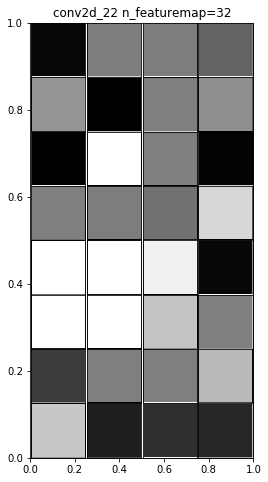

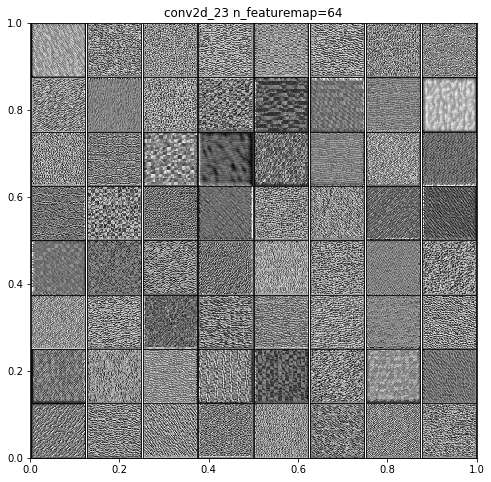

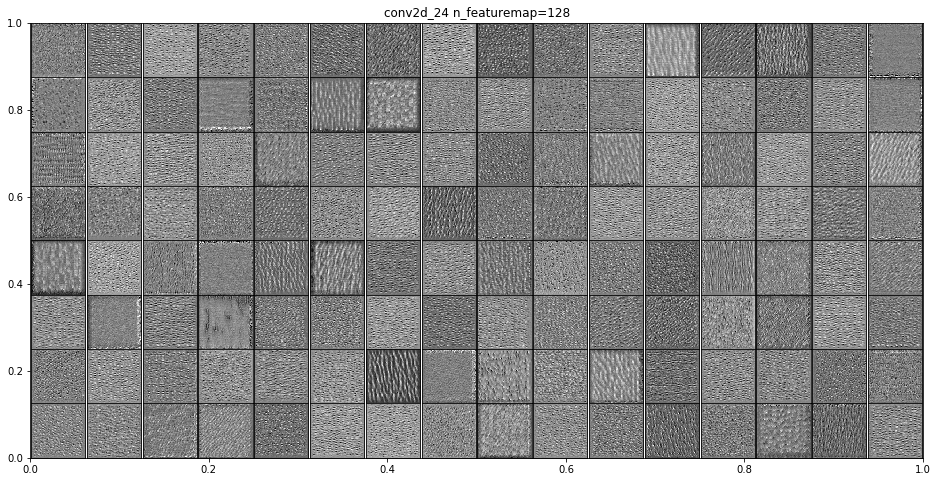

In [8]:
max_nfmap = np.Inf ## print ALL the images

visualizer = VisualizeImageMaximizeFmap(pic_shape = (96,96,1))
print("find images that maximize feature maps")
argimage = visualizer.find_images(input_img,
                                  layer_names,
                                  layer_dict, 
                                  max_nfmap)
print("plot them...")
visualizer.plot_images_wrapper(argimage,n_row = 8, scale = 1)

### Did the gradient ascent converge?

In [Kaggle's official blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html), the number of iterations for the gradient ascent is set to as low as 20. Do I really find the best image that maximizes the sum of the feature map? To answer to this question, I plotted the sum of the feature map over iterations. 

Not suprisingly, the gradient ascent did not converge at all!! I run the codes several times and look at different best images found by the gradient ascent (i.e., run the codes in the previous cell several times). It seems that the best image obtained and plotted above are virtually the same even when the algorithm did not coverge. I guess there are various numerical solutions to this optimization but they are vertually the same image after rescaling. 


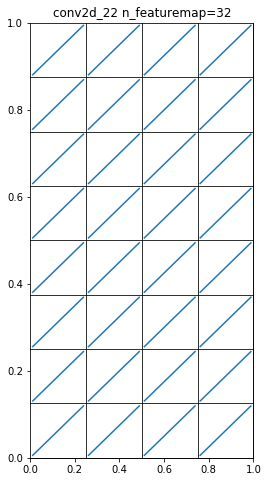

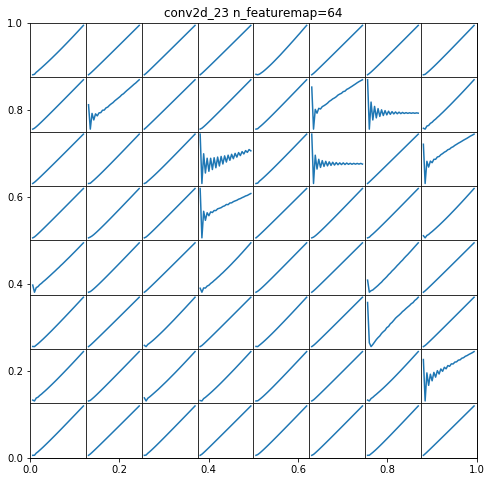

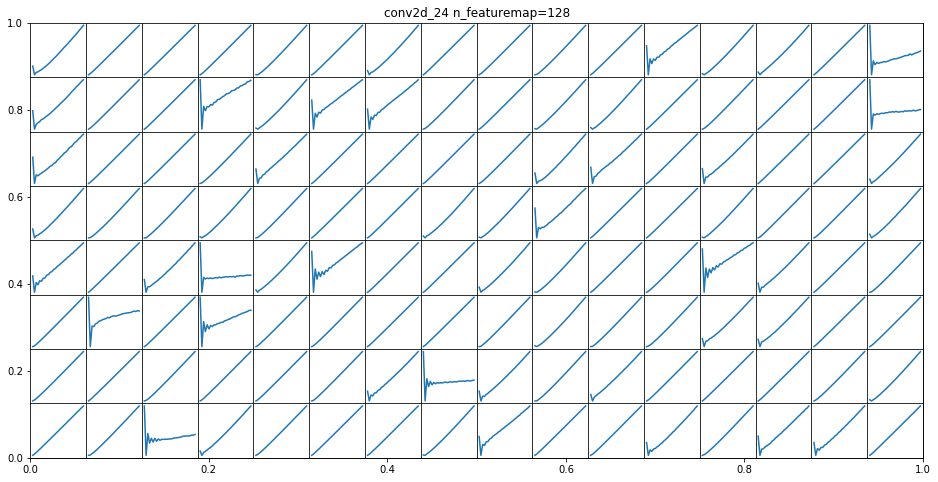

In [9]:
const  = 1
n_row = 8 
for layer_name in layer_names:
    n_fmap = len(argimage[layer_name])
    n_col = np.ceil(n_fmap/float(n_row))
    fig = plt.figure(figsize=(n_col*const,n_row*const))
    fig.subplots_adjust(hspace=0.001,wspace=0.001)
                        
    plt.title(layer_name + " n_featuremap=" + str(n_fmap))
    for count , value in enumerate(argimage[layer_name]):
        objective = value[1]
        ax = fig.add_subplot(n_row,n_col,count+1,
                            xticks=[],yticks=[])
        ax.plot(objective)
    plt.show()

# Visualizing VGG16

Let's learn to visualize layers of deep learning model for classification problem. Here I use VGG model following the discussion of [Keras's official blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html). VGG16 (also called OxfordNet) is a convolutional neural network architecture named after the Visual Geometry Group from Oxford, who developed it. It was used to win the [ILSVR (ImageNet)](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) competition in 2014.


Due to the proxy problem I cannot download and bulid model using keras.applications.VGG16 so here I take manual approach.

Step 1: Downloading data from [Github](https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5). This is a massive .h5 file (57MB).

Step 2: [The source code of keras.applications.VGG16](https://github.com/keras-team/keras/blob/master/keras/applications/vgg16.py) is available. It seems that we can manually set the weights to be the one locally available.


In [10]:
ls "vgg16"*

vgg16_weights_tf_dim_ordering_tf_kernels.h5*
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5*


## Some observations:

- Input shape is (None, None, None, 3).

This (probablly) means that the sample size and the frame sizes can be specified later. 
But the channel (RGB) is specified at the 3rd dimention and it must be 3? 
[Keras's official blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) sets the 1st dimention for the RGB specification i.e., (None,3,None,None). According to the [Keras's documentation about VGG16](https://keras.io/applications/#vgg16), you are allowed to chose the channel to come to the last dimention or the first dimention. But where can I set the dimention? I found my answer in K.image_data_format(). It shows that the default setting is 'channels_last'. Therefore, it makes sense that the VGG16 has 3 as the last dimention. 

In [11]:
import keras.backend as K
K.image_data_format()

'channels_last'

In [12]:
from keras.applications import VGG16

model = VGG16(include_top=False,weights=None)

## load the locally saved weights 
model.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

## show the deep learning model
model.summary()

input_img = model.layers[0].input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Here the max_nfmap is set to a low number because the number of feature maps is as large as 512 for block5, and this is too many to plot. Notice that although the frame size is set to (96, 96, 3), the frame size can be different: as long as the width and height are larger than 48. Great flexibility of deep learning model :D. This flexilibity is also discussed in the [Kaggle's blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html).

_"Note that we only go up to the last convolutional layer --we don't include fully-connected layers. The reason is that adding the fully connected layers forces you to use a fixed input size for the model (224x224, the original ImageNet format). By only keeping the convolutional modules, our model can be adapted to arbitrary input sizes."_


I observe similar results as  [Keras's official blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html):

- The first layer encode direction (looks diagonal lines) and color.
- Later layers mix the direction and colors together.
- Later layers look more complex and very staticy.

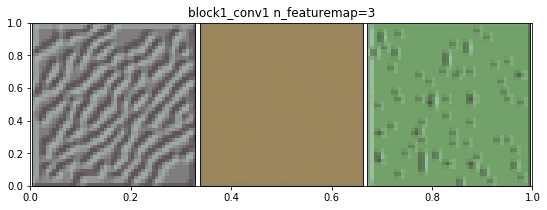

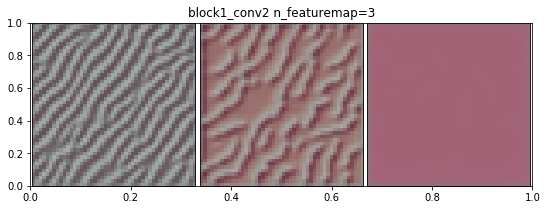

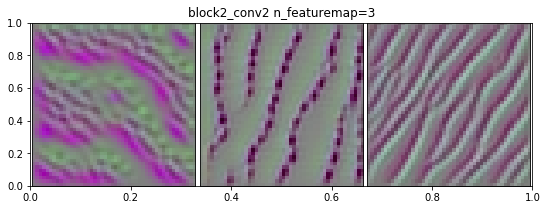

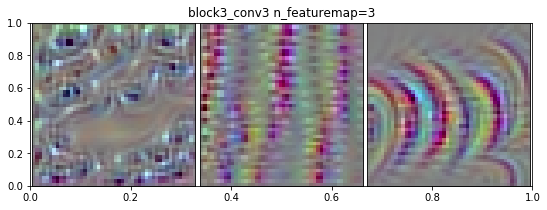

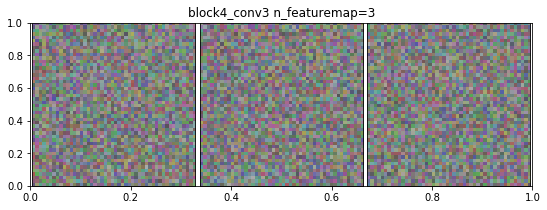

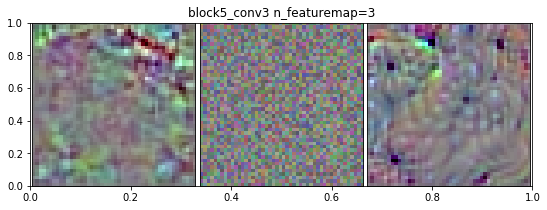

In [13]:

layer_names = ["block1_conv1","block1_conv2",
               "block2_conv2",
               "block3_conv3",
               "block4_conv3",
               "block5_conv3"]

## (196, 196, 3) , (96,96,3)
visualizer = VisualizeImageMaximizeFmap(pic_shape = (48,48,3))
max_nfmap = 3
argimage = visualizer.find_images(input_img,
                                  layer_names,
                                  layer_dict, 
                                  max_nfmap)
visualizer.plot_images_wrapper(argimage,n_row = 1, scale = 3)



## Use the full VGG16 models

### Finding an input that maximizes a specific class

In the facial landmark detection application, I did not visualize the final output layer. This is because knowing which image can maximize the x (or y) coordinate of the eye center does not give much insite about the model.
On the other hand, visualizing the final output layer gives interesting insights in the classification application, because knowing the which image can maximize the probability of being in one of the specific class is interesting. 

Following [Keras's official blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html), we will find the images that maximize specific classes.
Once again, I download weights from [here](https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5).
This weight is 10 times larger! (528 MB). This makes sense because the weights with top fully connected layer contains *138,357,544* parameters while the weights without the top layers contains 10 times less parameters (14,714,688 parameters).


In [20]:
ls "vgg16_weights_tf_dim"*

vgg16_weights_tf_dim_ordering_tf_kernels.h5*
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5*


Notice that the input dimention is set to (None, 224, 224, 3), indicating that our input image needs to have this size

In [63]:
model = VGG16(include_top=True,weights=None)
model.summary()
model.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels.h5")
input_img = model.layers[0].input
layer_dict = dict([(layer.name, layer) for layer in model.layers])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

It would be interesting to learn what kind of image can maximize the probability of picture having cats or dogs. The visualization becomes more interesting if we know the actual label/meaning of each of the 1000 classes. 


So before going into the details of the visualization, I extract the labels of each 1000 classes.
These classes are saved as a json object at [here]( https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json). This json object is used internally from the method [keras.applications.vgg16.decode_predictions()](https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py).

In [16]:
ls imagenet_class_index.json

imagenet_class_index.json*


In [66]:
import json
CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel = []
for i in range(1000):
    classlabel.append(CLASS_INDEX[str(i)][1])
classlabel = np.array(classlabel)
print(len(classlabel))

1000


### List all 1000 classes in order

- It is interesting to know that many of the class labels are related to dogs.
- As [Keras's public blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) says 
the 65th class is sea snake class and the 18th  magpie.

In [67]:
for i, lab in enumerate(classlabel):
    print("{:4.0f}: {:30}".format(i,str(lab))),
    if i % 3 == 2:
        print("")
        

   0: tench                             1: goldfish                          2: great_white_shark              
   3: tiger_shark                       4: hammerhead                        5: electric_ray                   
   6: stingray                          7: cock                              8: hen                            
   9: ostrich                          10: brambling                        11: goldfinch                      
  12: house_finch                      13: junco                            14: indigo_bunting                 
  15: robin                            16: bulbul                           17: jay                            
  18: magpie                           19: chickadee                        20: water_ouzel                    
  21: kite                             22: bald_eagle                       23: vulture                        
  24: great_grey_owl                   25: European_fire_salamander         26: common_newt             

 924: guacamole                       925: consomme                        926: hot_pot                        
 927: trifle                          928: ice_cream                       929: ice_lolly                      
 930: French_loaf                     931: bagel                           932: pretzel                        
 933: cheeseburger                    934: hotdog                          935: mashed_potato                  
 936: head_cabbage                    937: broccoli                        938: cauliflower                    
 939: zucchini                        940: spaghetti_squash                941: acorn_squash                   
 942: butternut_squash                943: cucumber                        944: artichoke                      
 945: bell_pepper                     946: cardoon                         947: mushroom                       
 948: Granny_Smith                    949: strawberry                      950: orange                  

## Is VGG16 doing its job?
Before visualizing the fully-connected layer's filters, I check if VGG16 is doing its highly-reputated job.
I took a picture of a dog from Google image, and see if the VGG16 can predict the picture correctly.

VGG16 correctly guesses that the picture has a dog! 
Amazingly, it also guesses the type of the dog correctly!


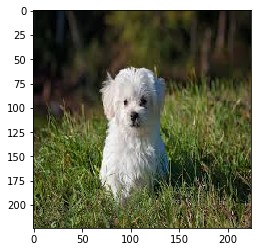

The top 5 labels
-----------------------------------------------------
Maltese_dog                    prob=0.474
Dandie_Dinmont                 prob=0.0834
soft-coated_wheaten_terrier    prob=0.0734
toy_poodle                     prob=0.0686
Lhasa                          prob=0.0521


In [111]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

image = load_img('./dog.jpg', target_size=(224, 224,3))
plt.imshow(image)
plt.show()
image = img_to_array(image)  #output Numpy-array
y_pred = model.predict(image.reshape(1,image.shape[0],image.shape[1],image.shape[2])).flatten()

## top 5 selected classes
top = 5
chosen_classes = classlabel[  np.argsort( y_pred )[::-1][:top] ]

print("The top {} labels".format(top))
print("-----------------------------------------------------")
for myclass in chosen_classes:
    myprob = y_pred[classlabel==myclass][0]
    print("{:30} prob={:4.3}".format(myclass,myprob))

## Visualization of the filters of the final output layers
Finally, I visualize the filters of output layers.
Here I choose the following 4 output classes for visualization.

- sea snake (just like [Keras's official blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html))
- magpie (just like [Keras's official blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html))
- bee eater
- pillow

The following codes look a bit complicated because of the double loop. 
The first loop goes over the four classes. 
The next while loop iterates until the gradient-ascent algorithm "converges".
In comparisons to my Model 4, VGG16 is more complex (with about 17 times more parameters (17=138357544/8051502)).
Therefore the simple gradient ascent algorithm yield quite different pictures every time it runs with different initial start image. As the solution to this optimization problem is not unique, it is expected to have a different images as the solution. However, the resulting picture should yield the probability of belonging to the corresponding class to be very high, as high as 1. Otherwise, it is most likely that the algorithm did not converge. 

From the trial and error, I found that the convergence (in terms of the probability of belonging to the class = 1) depends highly on the initial start image. For these reasons, my code runs until it finds the image that yieled high probability of belonging to the class.

## Observations

I was able to find pictures with 100% probability of being sea snake, magpie, cliff or siamang!

- The pictures that I found look a bit different from the one found by [Keras's official blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html). Expectedly.

- The sea snake image seems to have some curvy texture?
- The magpie image looks to have a texture of feather ... ? some beaks? If you say so.
- Do I see the colourful bee eater at the center? 
- The pillow image looks soft and fluffy..

I would not classify any of these pictures into sea snake or magpie! I wonder what would happen if I label them as not-sea-snake or not-magie, include as parts of the training data and retrain the models. (Is this the idea of GAN? Something I would love to learn.)  But I guess CNN look at pictures differently.
I will conclude this blog by quoting the comments from [Keras's official blog](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html):

_we should refrain from our natural tendency to anthropomorphize them and believe that they "understand", say, the concept of dog, or the appearance of a magpie, just because they are able to classify these objects with high accuracy. They don't, at least not to any any extent that would make sense to us humans._



The total number of times the gradient ascent needs to run: 11
sea_snake probability:  1.0

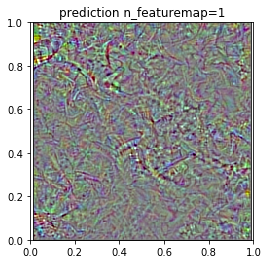

 The total number of times the gradient ascent needs to run: 50
magpie probability:  1.0

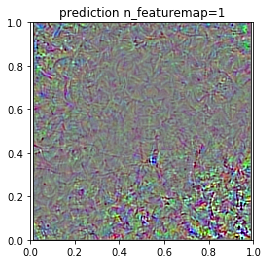

 The total number of times the gradient ascent needs to run: 4
bee_eater probability:  1.0

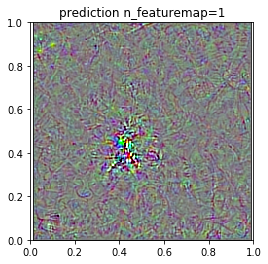

 The total number of times the gradient ascent needs to run: 10
pillow probability:  1.0

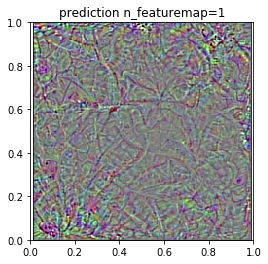

In [132]:
layer_output = layer_dict["predictions"].output


out_index = [65, 18, 92, 721]
for i in out_index:
    visualizer = VisualizeImageMaximizeFmap(pic_shape = (224,224,3))
    images = []
    probs  = []
    myprob = 0
    n_alg = 0
    while(myprob < 0.9):
        myimage = visualizer.find_images_for_layer(input_img,layer_output,[i],
                                                   picorig=True,n_iter=20)
        y_pred = model.predict(myimage[0][0]).flatten()
        myprob = y_pred[i]
        n_alg += 1

    print("The total number of times the gradient ascent needs to run: {}".format(n_alg))
    
    argimage = {"prediction":[myimage]}
    print("{} probability:".format(classlabel[i])),
    print("{:4.3}".format(myprob)),
    
    visualizer.plot_images_wrapper(argimage,n_row = 1, scale = 4)
